### NOTA: DESCARGAR EL REPOSITORIO DE GROUNDING DINO 

https://github.com/IDEA-Research/GroundingDINO

## Inicio

In [1]:
import os
import numpy as np
import supervision as sv
import cv2
from PIL import Image

HOME = os.getcwd()
print(HOME)

/home/enrique/Desktop/VARIOS/TFM


Configuraciones

In [3]:
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
WEIGHTS_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")

## Cargar modelo

In [4]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH);

/home/enrique/Desktop/VARIOS/TFM/GroundingDINO


final text_encoder_type: bert-base-uncased


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

## Uso del modelo

In [8]:
SOURCE_IMAGE_PATH = f"{HOME}/tree_images/1cm_maxint/P26_173.tif"
CLASSES = ['circles']
BOX_TRESHOLD = 0.01
TEXT_TRESHOLD = 0.9

# Define the maximum area threshold
MAX_AREA = 3000  # Example area threshold

Funciones de apoyo

In [ ]:
# Function to read image using PIL and convert to OpenCV format
def read_image_with_pil(image_path):
    with Image.open(image_path) as img:
        image = np.array(img)
    if image.dtype == np.float32:
        image = np.clip(image * 255, 0, 255).astype(np.uint8)
    image = np.nan_to_num(image, nan=0, posinf=255, neginf=0)
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    else:
        image_bgr = image
    return image_bgr

def read_image_with_pil(image_path):
    with Image.open(image_path) as img:
        image = np.array(img)
    if image.dtype == np.float32:
        image = np.clip(image * 255, 0, 255).astype(np.uint8)
    image = np.nan_to_num(image, nan=0, posinf=255, neginf=0)
    
    # Enhance contrast for grayscale images
    if len(image.shape) == 2:
        image = cv2.equalizeHist(image)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif len(image.shape) == 3 and image.shape[2] == 3:
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        for i in range(3):  # Apply histogram equalization to each channel
            image_bgr[:, :, i] = cv2.equalizeHist(image_bgr[:, :, i])
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    else:
        image_bgr = image
        for i in range(3):  # Apply histogram equalization to each channel
            image_bgr[:, :, i] = cv2.equalizeHist(image_bgr[:, :, i])
        image = image_bgr

    return image

# Function to filter detections by area
def filter_detections_by_area(detections, max_area):
    areas = (detections.xyxy[:, 2] - detections.xyxy[:, 0]) * (detections.xyxy[:, 3] - detections.xyxy[:, 1])
    filtered_indices = np.where(areas <= max_area)[0]
    filtered_detections = sv.Detections(
        xyxy=detections.xyxy[filtered_indices],
        confidence=detections.confidence[filtered_indices],
        class_id=np.array(detections.class_id)[filtered_indices] if detections.class_id is not None else np.zeros(len(filtered_indices), dtype=int),
        tracker_id=detections.tracker_id[filtered_indices] if detections.tracker_id is not None else None,
        data={key: np.array(value)[filtered_indices].tolist() for key, value in detections.data.items()}
    )
    return filtered_detections

Ejecución

In [9]:
# Read the image
image = read_image_with_pil(SOURCE_IMAGE_PATH)
caption = ", ".join(CLASSES)

# Example detections (replace with your actual detections)
detections, labels = model.predict_with_caption(
    image=image,
    caption=caption,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# Filter the detections
filtered_detections = filter_detections_by_area(detections, MAX_AREA)

# Create the BoxAnnotator object
box_annotator = sv.BoxAnnotator()

# Annotate the image with the filtered detections
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=filtered_detections)

# Draw the labels on the image
labels = [f"Class {i} {conf:.2f}" for i, conf in enumerate(filtered_detections.confidence)]
for (box, label) in zip(filtered_detections.xyxy, labels):
    x1, y1, x2, y2 = map(int, box)
    cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

'''# Display the annotated image
cv2.imshow("Annotated Image", annotated_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''
# Save the annotated image
cv2.imwrite("annotated_image.jpg", annotated_frame)


True

Mostrar resultados

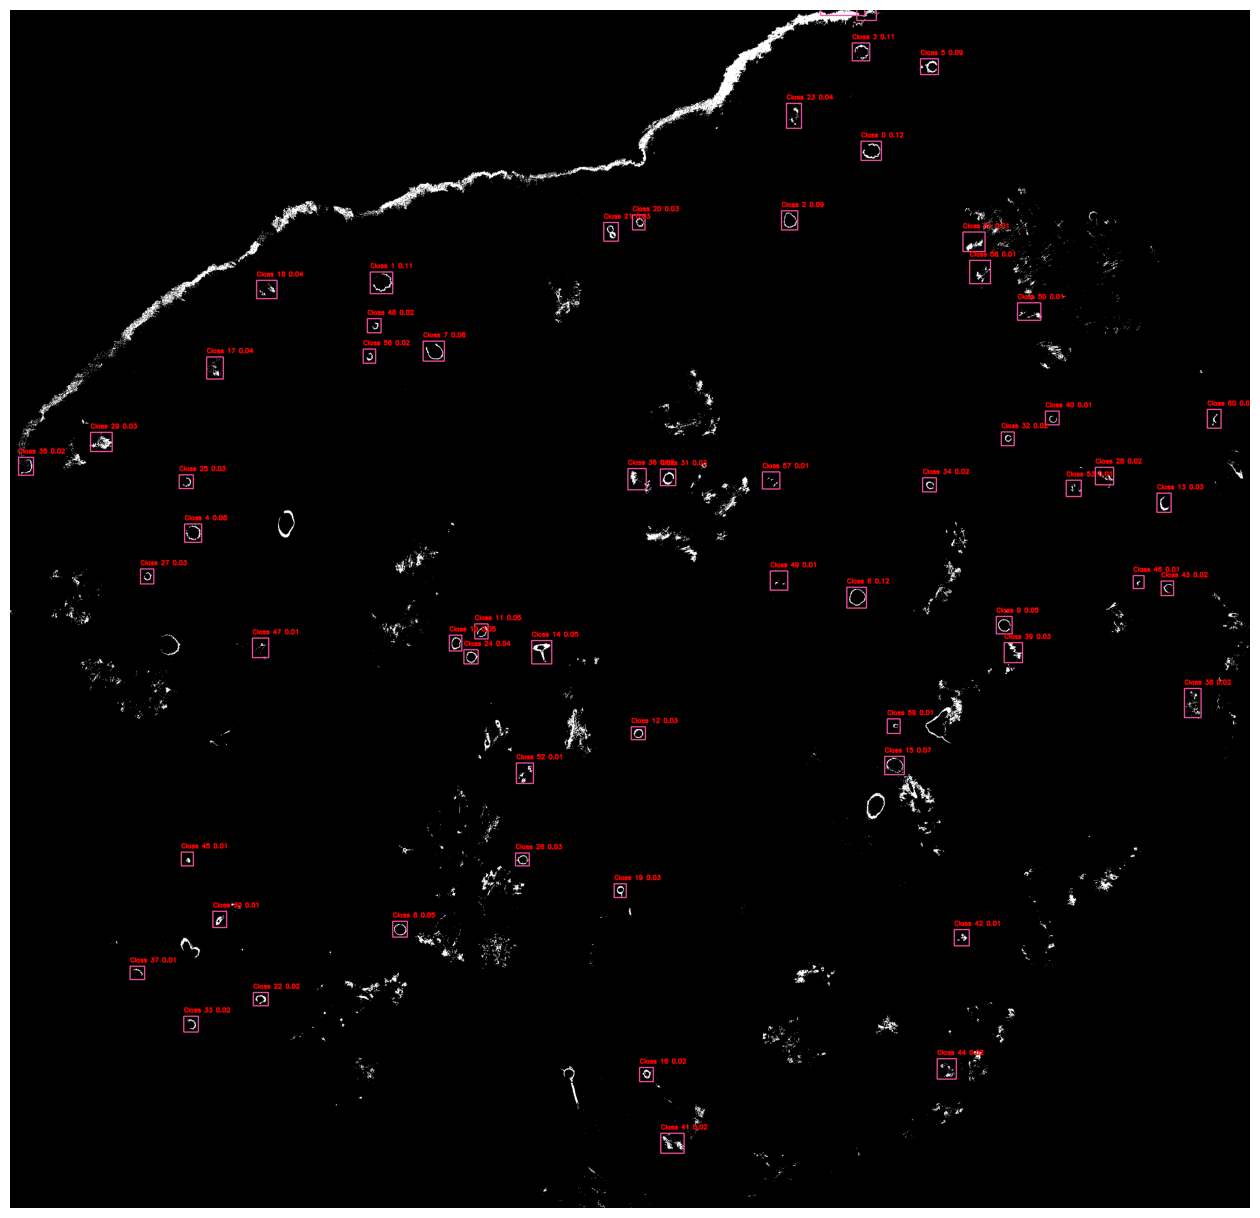

In [10]:
# Mostrar el frame anotado
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
plt.imshow(annotated_frame)
plt.axis('off')
plt.show()

### Guardado

Así sería

In [12]:
import numpy as np

def convert_to_yolo_format(detections, image_shape):
    yolo_labels = []
    img_height, img_width, _ = image_shape
    for box, class_id in zip(detections.xyxy, np.zeros_like(detections.xyxy)):
        x1, y1, x2, y2 = box
        x_center = ((x1 + x2) / 2) / img_width
        y_center = ((y1 + y2) / 2) / img_height
        width = (x2 - x1) / img_width
        height = (y2 - y1) / img_height
        yolo_labels.append(f"{0} {x_center} {y_center} {width} {height}")
    return yolo_labels

# Asumiendo que `image` es tu imagen de entrada
yolo_labels = convert_to_yolo_format(filtered_detections, image.shape)

# Guardar en un archivo .txt
with open("labels.txt", "w") as file:
    for label in yolo_labels:
        file.write(label + "\n")

Visualizar para verificar validez

In [13]:
import cv2
from PIL import Image
import numpy as np

def draw_boxes_from_yolo_labels(image_path, label_path):
    # Load the image using PIL
    pil_image = Image.open(image_path)
    image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    
    img_height, img_width, _ = image.shape

    # Read the YOLO labels from the file
    with open(label_path, "r") as file:
        lines = file.readlines()

    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)

        # Draw the box on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, str(int(class_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the image
    cv2.imshow("Image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
draw_boxes_from_yolo_labels(SOURCE_IMAGE_PATH, "labels.txt")

### Anotando toda la carpeta

In [15]:
from tqdm import tqdm

for folder in ['/home/enrique/Desktop/VARIOS/TFM/tree_images/1cm_density',
               '/home/enrique/Desktop/VARIOS/TFM/tree_images/1cm_maxint',
               '/home/enrique/Desktop/VARIOS/TFM/tree_images/1cm_meanint']:
    
    # Folder for labels
    labels_folder = f"{folder}_labels"
    os.makedirs(labels_folder, exist_ok=True)
    print(os.listdir(folder))
    
    # Lista de archivos de imagen
    image_files = [f for f in os.listdir(folder) if f.lower().endswith('.tif')]
    
    for image_filename in tqdm(image_files, desc=f'Processing images in {folder}'):
        try:
            # Read the image
            image_path = os.path.join(folder, image_filename)
            image = read_image_with_pil(image_path)

            # Example detections (replace with your actual detections)
            detections, labels = model.predict_with_caption(
                image=image,
                caption=", ".join(CLASSES),
                box_threshold=BOX_TRESHOLD,
                text_threshold=TEXT_TRESHOLD
            )

            # Filter the detections
            filtered_detections = filter_detections_by_area(detections, MAX_AREA)

            # Asumiendo que image es tu imagen de entrada
            yolo_labels = convert_to_yolo_format(filtered_detections, image.shape)

            # Guardar en un archivo .txt
            label_filename = os.path.splitext(image_filename)[0] + ".txt"
            path_guardado = os.path.join(labels_folder, label_filename)
            with open(path_guardado, "w") as file:
                for label in yolo_labels:
                    file.write(label + "\n")
        
        except Exception as e:
            print(f"Error processing {image_filename}: {e}")


'from tqdm import tqdm\n\nfor folder in [\'/home/enrique/Desktop/VARIOS/TFM/tree_images/1cm_density\',\n               \'/home/enrique/Desktop/VARIOS/TFM/tree_images/1cm_maxint\',\n               \'/home/enrique/Desktop/VARIOS/TFM/tree_images/1cm_meanint\']:\n    \n    # Folder for labels\n    labels_folder = f"{folder}_labels"\n    os.makedirs(labels_folder, exist_ok=True)\n    print(os.listdir(folder))\n    \n    # Lista de archivos de imagen\n    image_files = [f for f in os.listdir(folder) if f.lower().endswith(\'.tif\')]\n    \n    for image_filename in tqdm(image_files, desc=f\'Processing images in {folder}\'):\n        try:\n            # Read the image\n            image_path = os.path.join(folder, image_filename)\n            image = read_image_with_pil(image_path)\n\n            # Example detections (replace with your actual detections)\n            detections, labels = model.predict_with_caption(\n                image=image,\n                caption=", ".join(CLASSES),\n   

### Prueba extra (no usada): Visualizando detección en 3 capas

In [16]:
CLASSES = ['circle']
BOX_TRESHOLD = 0.008
TEXT_TRESHOLD = 0.01

# Define the maximum area threshold
MAX_AREA = 3000  # Example area threshold

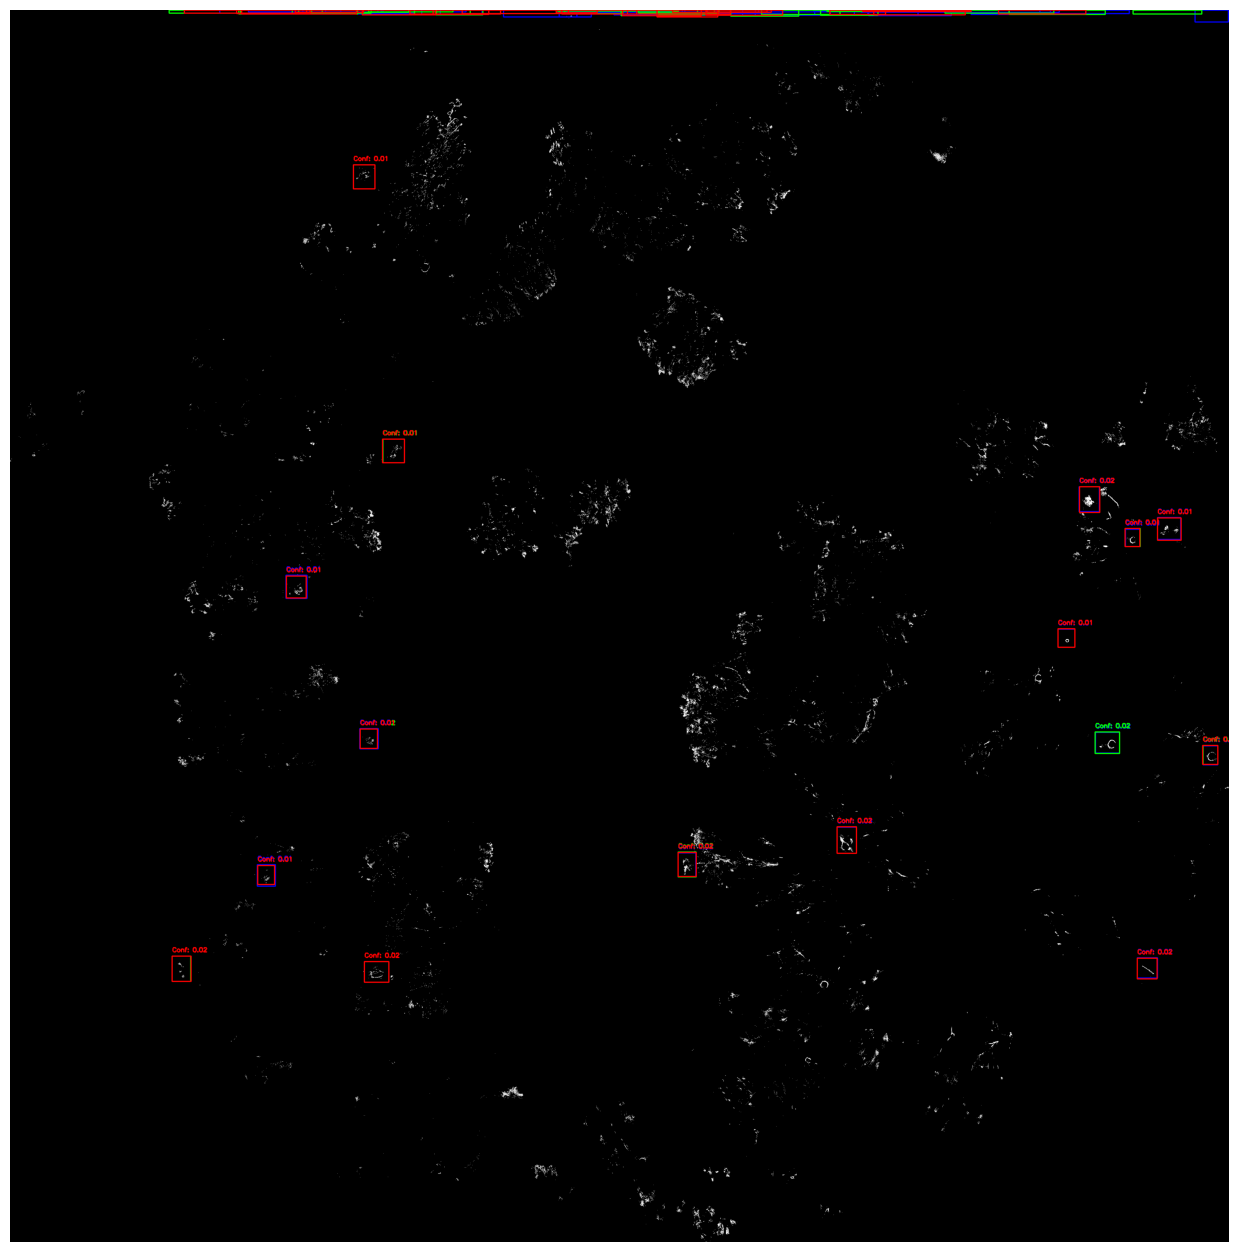

In [20]:
# Define the folders
folders = [
    '/home/enrique/Desktop/VARIOS/TFM/tree_images/1cm_density',
    '/home/enrique/Desktop/VARIOS/TFM/tree_images/1cm_maxint',
    '/home/enrique/Desktop/VARIOS/TFM/tree_images/1cm_meanint'
]

# Colors for each variant
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Red, Green, Blue

# Select a random image filename from the first folder
import random
random_image_filename = random.choice([f for f in os.listdir(folders[0]) if f.lower().endswith('.tif')])

# Process the selected random image in all three folders
all_filtered_detections = []
for i, folder in enumerate(folders):
    labels_folder = f"{folder}_labels"
    os.makedirs(labels_folder, exist_ok=True)
    
    image_path = os.path.join(folder, random_image_filename)
    image = read_image_with_pil(image_path)

    # Example detections (replace with your actual detections)
    detections, labels = model.predict_with_caption(
        image=image,
        caption=", ".join(CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    # Filter the detections
    filtered_detections = filter_detections_by_area(detections, MAX_AREA)
    all_filtered_detections.append(filtered_detections)

    # Convert detections to YOLO format
    yolo_labels = convert_to_yolo_format(filtered_detections, image.shape)

    # Save labels to a .txt file
    label_filename = os.path.splitext(random_image_filename)[0] + ".txt"
    path_guardado = os.path.join(labels_folder, label_filename)
    with open(path_guardado, "w") as file:
        for label in yolo_labels:
            file.write(label + "\n")

# Annotate one of the images (e.g., from the first folder)
annotated_image_path = os.path.join(folders[0], random_image_filename)
annotated_image = read_image_with_pil(annotated_image_path)

# Create the BoxAnnotator object
box_annotator = sv.BoxAnnotator()

# Annotate the image with the filtered detections from all variants
for i, filtered_detections in enumerate(all_filtered_detections):
    color = colors[i]
    for (box, confidence) in zip(filtered_detections.xyxy, filtered_detections.confidence):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(annotated_image, f"Conf: {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the annotated image
plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()